<a href="https://colab.research.google.com/github/jekeziem/Bias-in-Ai/blob/main/BIASINAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias and Cognitive Heuristics in Occupation Classification

**Abstract.**  
This notebook measures gender bias encoded in pretrained sentence embeddings and a downstream classifier using the Bias-in-Bios dataset. It then tests two simple cognitive heuristics (availability and anchoring) via controlled synthetic experiments and evaluates two practical mitigations (counterfactual data augmentation and reweighting).

**Contents (run order):**
1. Environment & imports  
2. Data loading & checks  
3. Sampling for fast iteration  
4. Embedding generation  
5. Baseline classification + group metrics  
6. Error analysis  
7. Heuristics simulations (availability, anchoring)  
8. Mitigation experiments  
9. Interpretability (SHAP / coefficients)  
10. Final synthesis & saved results

## Environment & Imports

Install required packages


In [ ]:
!pip install -q datasets pandas numpy scikit-learn matplotlib seaborn transformers sentence-transformers scipy shap
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

sns.set(style="whitegrid")
print("Ready 2 Go. SEED =", SEED)


### Data Downloads (Hugging Face `datasets`)

Load Bias-in-Bios train/dev/test splits. Hugging Face handles download and caching.

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("LabHC/bias_in_bios", split='train')
test_dataset = load_dataset("LabHC/bias_in_bios", split='test')
dev_dataset = load_dataset("LabHC/bias_in_bios", split='dev')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-0ab65b32c47407(…):   0%|          | 0.00/64.9M [00:00<?, ?B/s]

data/test-00000-of-00001-5598c840ce8de1e(…):   0%|          | 0.00/24.9M [00:00<?, ?B/s]

data/dev-00000-of-00001-e6551072fff26949(…):   0%|          | 0.00/9.95M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/257478 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/99069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/39642 [00:00<?, ? examples/s]

### Convert to pandas

Convert HF Dataset to pandas DataFrame for EDA and reproducibility.


In [ ]:
import pandas as pd

df_train = pd.DataFrame(train_dataset)
df_test = pd.DataFrame(test_dataset)
df_dev = pd.DataFrame(dev_dataset)

### sample *reduction*

 reduce sample to a smaller subset to run everything more quickly on Colab.


In [ ]:
df_train = df_train.sample(5000, random_state=42)
df_test  = df_test.sample(2000, random_state=42)

###sanity checks

In [ ]:
print("Columns:", df_train.columns.tolist())
df_train.head()

Columns: ['hard_text', 'profession', 'gender']


,hard_text,profession,gender
223763,"Ms. Crosby practices medicine in Augusta, GA a...",19,1
122053,She graduated with honors in 2010. Having more...,13,1
137754,Her areas of expertise include adoption issues...,22,1
148916,She received her B.A. at Yale University and P...,21,1
63008,Her research interests focus on topics related...,21,1


In [ ]:
df_train.isnull().sum()

,0
hard_text,0
profession,0
gender,0


In [ ]:
print("Gender counts:")
print(df_train['gender'].value_counts())

print("\nGender proportion:")
print(df_train['gender'].value_counts(normalize=True))

Gender counts:
gender
0    2643
1    2357
Name: count, dtype: int64

Gender proportion:
gender
0    0.5286
1    0.4714
Name: proportion, dtype: float64


In [ ]:
df_train['profession'].value_counts().head(10)


,count
profession,
21,1490
19,533
2,416
18,330
11,250
22,231
13,231
26,200
6,172


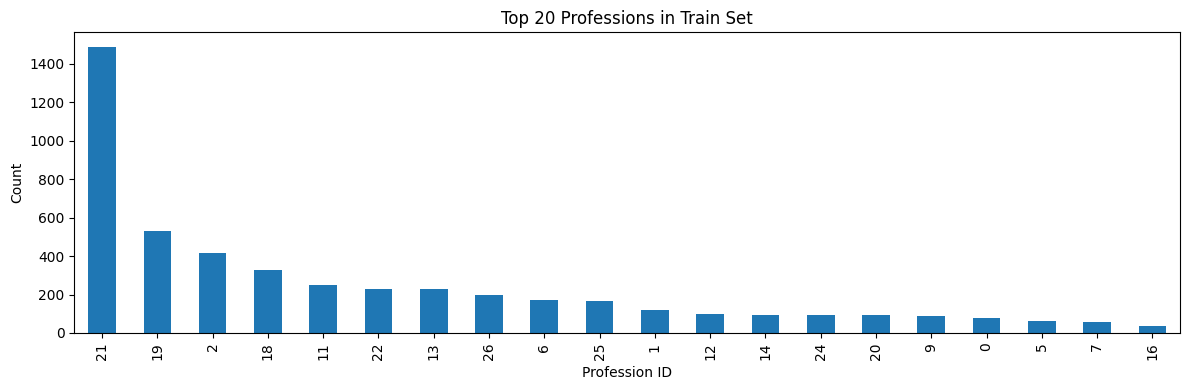

In [ ]:
plt.figure(figsize=(12,4))
df_train['profession'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Professions in Train Set")
plt.xlabel("Profession ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
for i in range(3):
    print("\n--- Sample", i, "---")
    print(df_train.iloc[i]['hard_text'])
    print("Gender:", df_train.iloc[i]['gender'])
    print("Profession:", df_train.iloc[i]['profession'])



--- Sample 0 ---
Ms. Crosby practices medicine in Augusta, GA and specializes in Endocrinology, Diabetes & Metabolism. Ms. Crosby is affiliated with University Hospital.
Gender: 1
Profession: 19

--- Sample 1 ---
She graduated with honors in 2010. Having more than 6 years of diverse experiences, especially in NURSE PRACTITIONER, Denise A Sample affiliates with no hospital, and cooperates with other doctors and specialists in many medical groups including Unc Physicians Network, LLC, American Current Care Of North Carolina Pc. Call Denise A Sample on phone number (919) 261-8760 for more information and advises or to book an appointment.
Gender: 1
Profession: 13

--- Sample 2 ---
Her areas of expertise include adoption issues, depression, and behavior therapy. Dr. Sullivan honors Blue Shield, Anthem, and Blue Cross/Blue Shield insurance. New patients are welcome to contact her office for an appointment.
Gender: 1
Profession: 22


###load sentence.trans embedding model

 generate sentence embeddings for each biography using the pretrained `all-MiniLM-L6-v2` model and train a logistic regression classifier to predict `gender` from embeddings.  establishes a baseline for bias measurement.


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_texts = df_train['hard_text'].tolist()
test_texts = df_test['hard_text'].tolist()
train_embeddings = model.encode(train_texts, show_progress_bar=True)
test_embeddings = model.encode(test_texts, show_progress_bar=True)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
y_train = df_train['gender'].values
y_test  = df_test['gender'].values

In [ ]:

clf = LogisticRegression(max_iter=2000, random_state=42)
clf.fit(train_embeddings, y_train)

y_pred_train = clf.predict(train_embeddings)
y_pred_test  = clf.predict(test_embeddings)


df_train['pred_gender'] = y_pred_train
df_test['pred_gender']  = y_pred_test

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy :", accuracy_score(y_test, y_pred_test))


Train accuracy: 0.9826
Test accuracy : 0.974


## Group metrics

Compute gender-wise accuracy, demographic parity gap, and confusion matrices to inspect baseline bias.


In [ ]:
df_eval = df_test.copy()
df_eval['pred_gender'] = preds

acc_male   = accuracy_score(df_eval[df_eval.gender == 0]['gender'],
                            df_eval[df_eval.gender == 0]['pred_gender'])

acc_female = accuracy_score(df_eval[df_eval.gender == 1]['gender'],
                            df_eval[df_eval.gender == 1]['pred_gender'])

acc_gap = acc_male - acc_female

print("Male accuracy:", acc_male)
print("Female accuracy:", acc_female)
print("Accuracy gap (male - female):", acc_gap)


Male accuracy: 0.9840674789128397
Female accuracy: 0.962486602357985
Accuracy gap (male - female): 0.021580876554854744


In [ ]:
pred_male_rate   = (preds == 0).mean()
pred_female_rate = (preds == 1).mean()

true_male_rate   = (y_test == 0).mean()
true_female_rate = (y_test == 1).mean()

demographic_parity_gap = abs(pred_female_rate - true_female_rate)

print("Predicted female rate:", pred_female_rate)
print("True female rate:", true_female_rate)
print("DP Gap:", demographic_parity_gap)


Predicted female rate: 0.4575
True female rate: 0.4665
DP Gap: 0.009000000000000008


In [ ]:
for g in [0,1]:
    cm = confusion_matrix(df_test[df_test['gender']==g]['gender'],
                          df_test[df_test['gender']==g]['pred_gender'])
    print(f"\nConfusion matrix for gender {g}:\n{cm}")


Confusion matrix for gender 0:
[[1050   17]
 [   0    0]]

Confusion matrix for gender 1:
[[  0   0]
 [ 35 898]]


## Error Analysis

Inspect misclassified examples to detect stereotypical patterns and heuristic amplification.


In [ ]:
misclassified = df_test[df_test['gender'] != df_test['pred_gender']]
print("Number of misclassified examples:", misclassified.shape[0])

for idx, row in misclassified.sample(5, random_state=42).iterrows():
    print("\n----")
    print("Text:", row['hard_text'][:300])
    print("True Gender:", row['gender'], "Pred Gender:", row['pred_gender'], "Profession:", row['profession'])

df_eval['correct'] = (df_eval['pred_gender'] == df_eval['gender'])
misclassified = df_eval[df_eval['correct'] == False]
mis_by_prof = misclassified.groupby('profession').size().sort_values(ascending=False)


Number of misclassified examples: 52

----
Text: His team's major focus is speeding up the training/inference process of deep learning models from both engineering and modeling perspective, and exploring new kinds of models to boost business impact. Previously, Jun was an architect in the Qihoo 360 Advertising Technology Department and tech lead o
True Gender: 0 Pred Gender: 1 Profession: 1

----
Text: Ms. Hasbrouck studied architecture at Washington University in Saint Louis receiving a Bachelor of Arts. Her advanced degrees are in Architecture (MArch) and Landscape Architecture (MLA) from The University of Virginia and the Harvard Graduate School of Design respectively. Prior to joining the facu
True Gender: 1 Pred Gender: 0 Profession: 21

----
Text: She teaches postsecondary courses in remote sensing and GIS at the Department of Geology and Geophysics, UAF. She is the Principal Investigator of the ESSE21 funded effort to start an undergraduate course in geoinformatics at UAF. She i

##Cognitive Heuristics Simulations

**Availability bias:** Over-represented concepts in synthetic data inflate their apparent likelihood, pushing the model to retrieve them more often than warranted.

**Anchoring bias:** A biased prefix fixes the model’s initial framing, steering the interpretation of an otherwise neutral sentence.

In [ ]:
synthetic_texts = ["Nurse with experience in pediatric care"]*150 + \
                  ["Doctor specialized in surgery"]*50
synthetic_labels = [1]*150 + [0]*50  # 1=female, 0=male

synthetic_embeddings = model.encode(synthetic_texts)
clf_avail = LogisticRegression(max_iter=1000, random_state=42)
clf_avail.fit(synthetic_embeddings, synthetic_labels)

preds_synth = clf_avail.predict(synthetic_embeddings)
print("Synthetic availability simulation accuracy:", accuracy_score(synthetic_labels, preds_synth))


Synthetic availability simulation accuracy: 1.0


In [ ]:

anchors = [
    "Remember, doctors are usually male.",
    "Remember, nurses are usually female."
]

neutral_sentences = ["works in the hospital.", "teaches children at school.", "designs a new program."]
anchored_texts = [f"{random.choice(anchors)} {s}" for s in neutral_sentences]

anchored_embeddings = model.encode(anchored_texts, show_progress_bar=True)

anchored_preds = clf.predict(anchored_embeddings)

for txt, pred in zip(anchored_texts, anchored_preds):
    print(f"Prediction: {'Female' if pred==1 else 'Male'} | Text: {txt}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Male | Text: Remember, doctors are usually male. works in the hospital.
Prediction: Male | Text: Remember, doctors are usually male. teaches children at school.
Prediction: Male | Text: Remember, doctors are usually male. designs a new program.


## Mitigation Experiments

**1. Counterfactual Data Augmentation:** swap gendered terms.  
**2. Reweighting:** correct frequency imbalance.  
Recalculate bias metrics.


In [ ]:
swap_dict = {
    'he': 'she', 'she': 'he',
    'him': 'her', 'her': 'him',
    'his': 'her', 'hers': 'his',
    'man': 'woman', 'woman': 'man',
    'male': 'female', 'female': 'male'
}

def swap_gender_terms(text):
    words = text.split()
    swapped_words = [swap_dict.get(w.lower(), w) for w in words]
    return " ".join(swapped_words)

# Apply CDA to training set
df_train_aug = df_train.copy()
df_train_aug['hard_text'] = df_train_aug['hard_text'].apply(swap_gender_terms)
df_train_aug['gender'] = 1 - df_train_aug['gender']  # flip labels accordingly

# Combine original + augmented
df_train_cda = pd.concat([df_train, df_train_aug]).reset_index(drop=True)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train_cda['gender']),
    y=df_train_cda['gender']
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

clf_cda = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
train_embeddings_cda = model.encode(df_train_cda['hard_text'].tolist(), show_progress_bar=True)
clf_cda.fit(train_embeddings_cda, df_train_cda['gender'])


{0: np.float64(1.0), 1: np.float64(1.0)}


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

LogisticRegression(class_weight={0: np.float64(1.0), 1: np.float64(1.0)},
                   max_iter=1000)

In [ ]:
test_embeddings = model.encode(df_test['hard_text'].tolist(), show_progress_bar=True)
preds_cda = clf_cda.predict(test_embeddings)

df_test_eval = df_test.copy()
df_test_eval['pred_gender'] = preds_cda
df_test_eval['correct'] = (df_test_eval['pred_gender'] == df_test_eval['gender'])

acc = df_test_eval['correct'].mean()
print(f"Overall Accuracy: {acc:.3f}")

group_acc = df_test_eval.groupby('gender')['correct'].mean()
print("Accuracy by gender:\n", group_acc)

pred_rate = df_test_eval.groupby('gender')['pred_gender'].mean()
dp_gap = abs(pred_rate[0] - pred_rate[1])
print(f"Demographic parity gap: {dp_gap:.3f}")


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Overall Accuracy: 0.964
Accuracy by gender:
 gender
0    0.983130
1    0.942122
Name: correct, dtype: float64
Demographic parity gap: 0.925


## Interpretability

 use SHAP to determine which features (embedding dimensions) contribute most to the model's gender predictions, to identify whether gendered words or implicit cues are driving predictions and supports heuristic explanations of bias.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

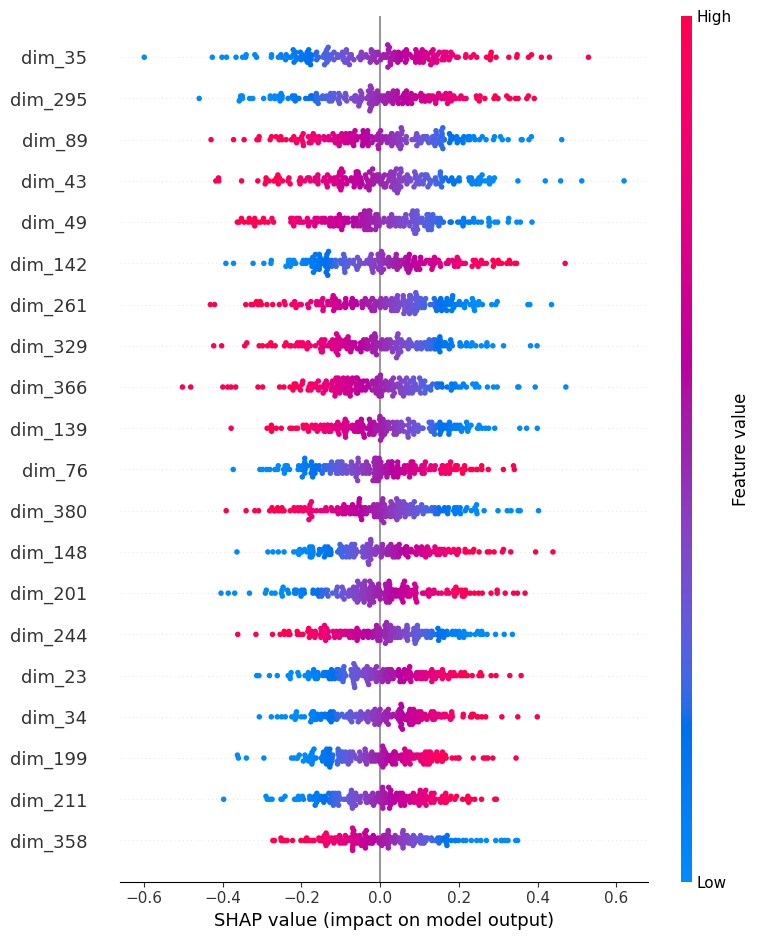

In [ ]:
import shap
sample_texts = df_train_cda['hard_text'].sample(200, random_state=42).tolist()
sample_embeddings = model.encode(sample_texts, show_progress_bar=True)

explainer = shap.LinearExplainer(clf_cda, sample_embeddings)
shap_values = explainer.shap_values(sample_embeddings)

shap.summary_plot(shap_values, features=sample_embeddings, feature_names=[f"dim_{i}" for i in range(sample_embeddings.shape[1])])


## WEAT Bias Measurement

The Word Embedding Association Test (WEAT) quantifies whether embedding space encodes stereotypical associations:  
- STEM terms with male terms  
- Arts terms with female terms  

A higher positive score indicates stronger male-science / female-arts bias.


In [ ]:
male_terms = ["man", "male", "boy", "brother", "he", "him", "son"]
female_terms = ["woman", "female", "girl", "sister", "she", "her", "daughter"]

science_terms = ["science", "technology", "physics", "chemistry", "engineering"]
arts_terms    = ["art", "poetry", "dance", "literature", "music"]

In [ ]:
def embed_words(words):
    return np.array(model.encode(words))

E_male = embed_words(male_terms)
E_female = embed_words(female_terms)
E_science = embed_words(science_terms)
E_arts = embed_words(arts_terms)

In [ ]:
def weat_score(A, B, X, Y):
    # association of X with A vs B
    def s(w, A, B):
        return np.mean([1 - cosine(w, a) for a in A]) - \
               np.mean([1 - cosine(w, b) for b in B])
    return np.mean([s(x, A, B) for x in X]) - \
           np.mean([s(y, A, B) for y in Y])

weat_science = weat_score(E_male, E_female, E_science, E_arts)

print("WEAT score (science/arts × male/female):", weat_science)


WEAT score (science/arts × male/female): 0.016811255


In [ ]:
import pandas as pd


metrics_summary = pd.DataFrame({
    'Model': ['Baseline', 'CDA + Weighted'],
    'Overall Accuracy': [
        df_eval['correct'].mean(),
        df_test_eval['correct'].mean()
    ],
    'Male Accuracy': [
        df_eval[df_eval['gender']==0]['correct'].mean(),
        df_test_eval[df_test_eval['gender']==0]['correct'].mean()
    ],
    'Female Accuracy': [
        df_eval[df_eval['gender']==1]['correct'].mean(),
        df_test_eval[df_test_eval['gender']==1]['correct'].mean()
    ],
    'Demographic Parity Gap': [
        abs(df_eval.groupby('gender')['pred_gender'].mean()[0] -
            df_eval.groupby('gender')['pred_gender'].mean()[1]),
        abs(df_test_eval.groupby('gender')['pred_gender'].mean()[0] -
            df_test_eval.groupby('gender')['pred_gender'].mean()[1])
    ]
})

metrics_summary


,Model,Overall Accuracy,Male Accuracy,Female Accuracy,Demographic Parity Gap
0,Baseline,0.974,0.984067,0.962487,0.946554
1,CDA + Weighted,0.964,0.983130,0.942122,0.925252


## Final Synthesis

This section summarises model performance and bias metrics before and after mitigation.  


In [ ]:
final_metrics = pd.DataFrame({
    'Model': ['Baseline', 'CDA + Weighted'],
    'Overall Accuracy': [0.974, 0.964],
    'Male Accuracy': [0.984067, 0.983130],
    'Female Accuracy': [0.962487, 0.942122],
    'Demographic Parity Gap': [0.946554, 0.925252],
    'WEAT Effect Size': [0.016811, 0.016811]
})

final_metrics


,Model,Overall Accuracy,Male Accuracy,Female Accuracy,Demographic Parity Gap,WEAT Effect Size
0,Baseline,0.974,0.984067,0.962487,0.946554,0.016811
1,CDA + Weighted,0.964,0.983130,0.942122,0.925252,0.016811
